# Get Setup

In [1]:
# we need torch 1.12+ and torchvision 0.13+# 
%load_ext autoreload
%autoreload 2
try:
    print("OK")
    import torch
    import torchvision

    assert float(torch.__version__.split(".")[0]) > 1 or int(
        torch.__version__.split(".")[1]) > 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio -- extra-index-url https: // download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

OK
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# try to get torchinfo, if doesn't exist, install it
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

# try to import the going_modular directory, download it from github if it doesn't exist
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    raise FileNotFoundError

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [4]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# creat dataloaders

In [6]:
from going_modular import data_setup
from torchvision import transforms

# creat image size (224,224)
IMG_SIZE = 224  # comes from table 3 of the ViT paper

# create transforms
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"manually created transforms: {manual_transforms}")

manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# create batch size 32, the paper used 4096.
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=0)

len(train_dataloader), len(test_dataloader), class_names  # (32, 32, 3a)

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# get batch images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

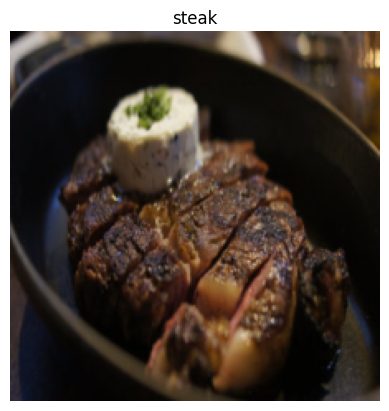

In [9]:
# plot image

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
height = 224
width = 224
color_chanel = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size ** 2)
embedding_layer_input_shape = (height, width, color_chanel)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_chanel)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

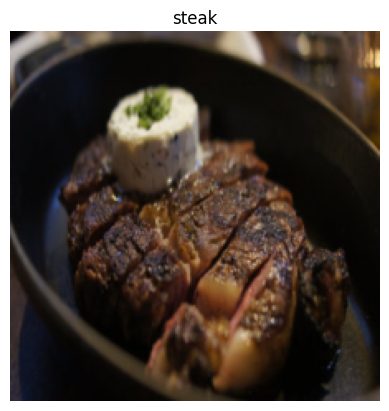

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

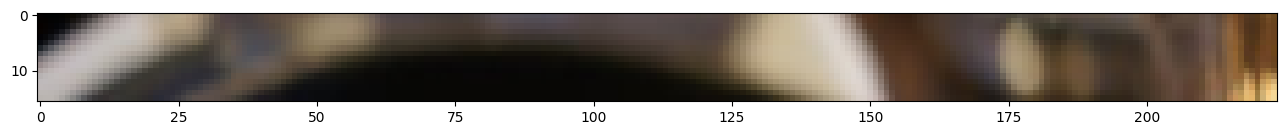

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

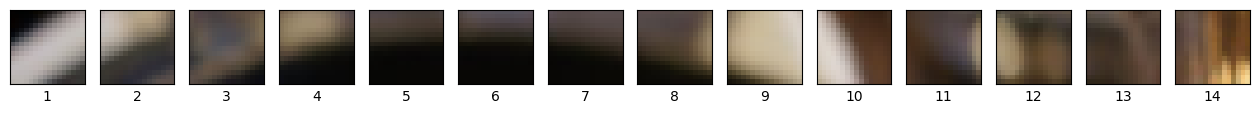

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "image should be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

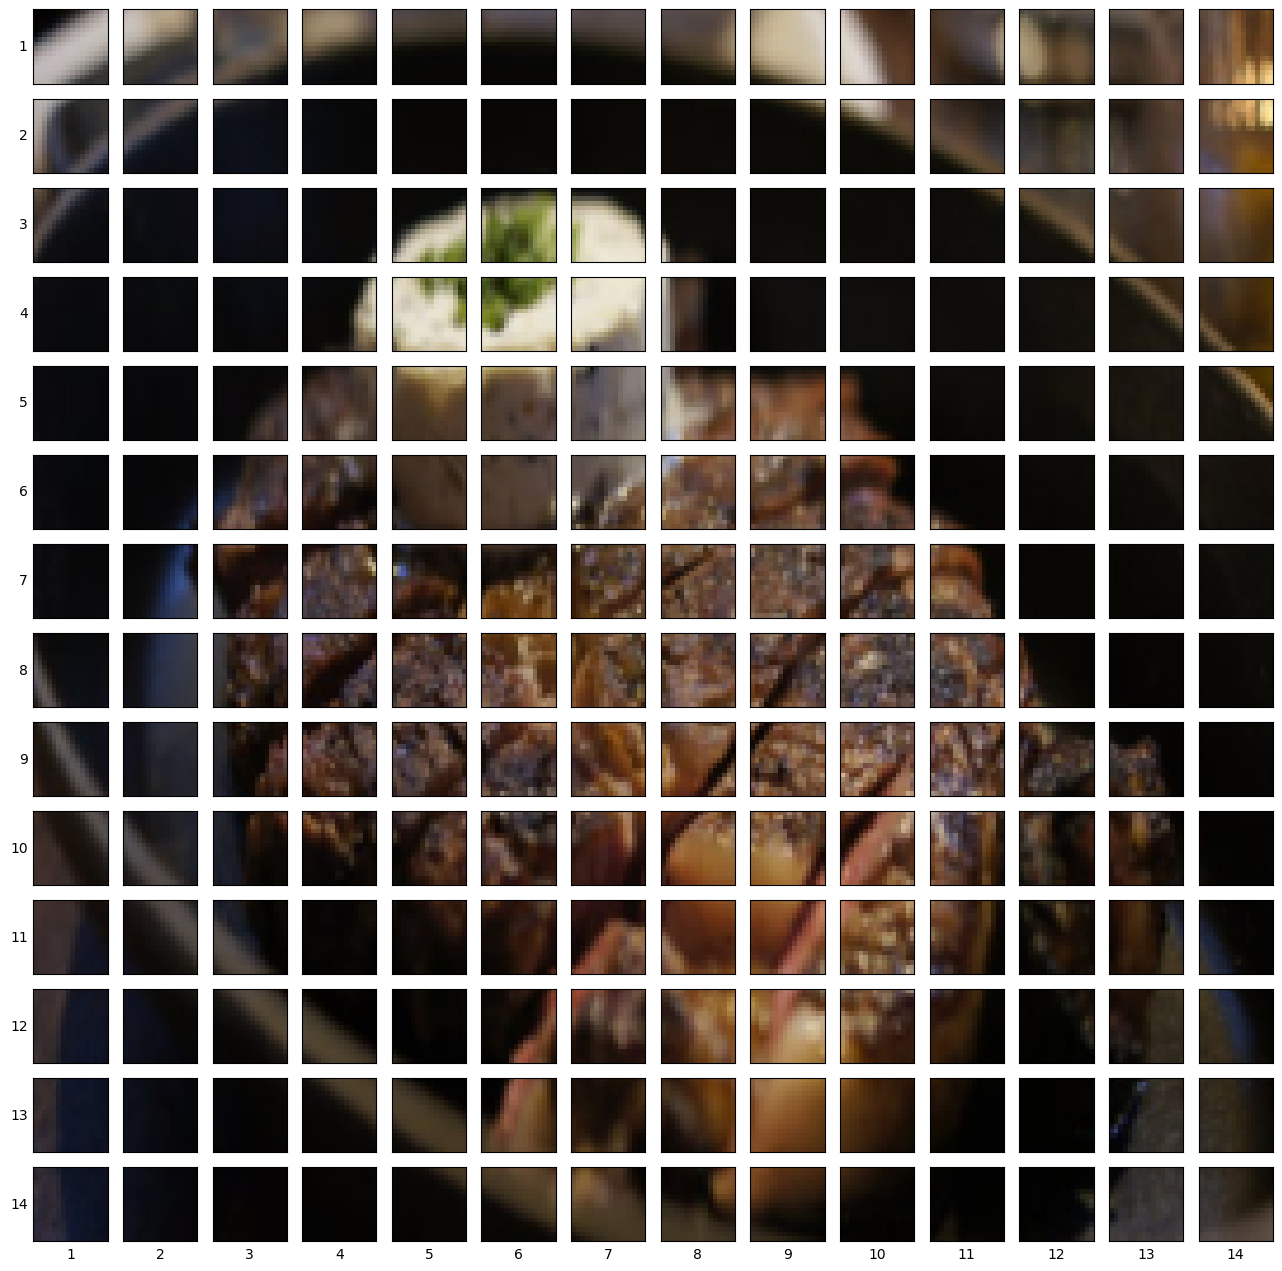

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "image should be divisible by patch size"

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size,
                         patch_width:patch_width + patch_size, :])
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_ylabel(i + 1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center"
                             )
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


In [15]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, padding=0, stride=patch_size)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

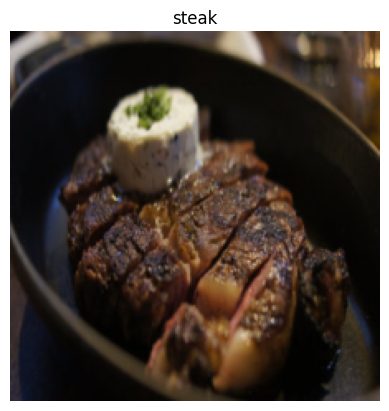

In [16]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [17]:
# pass the image
image_out_of_conv = conv2d(image.unsqueeze(0))  #  add batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [18]:
image_out_of_conv.requires_grad

True

showing random convolutional features maps from indexes: [148, 348, 80, 71, 742]


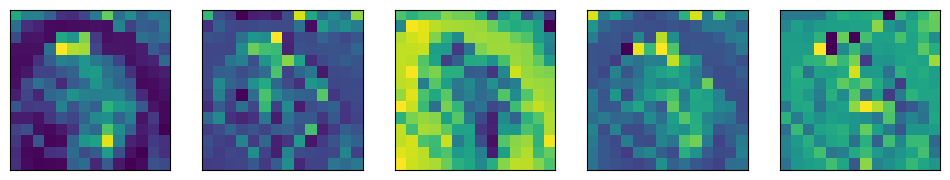

In [19]:
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"showing random convolutional features maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]  #  index on the output axis
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

In [22]:
image_out_of_flatten = flatten_layer(image_out_of_conv)
print(image_out_of_flatten.shape)

torch.Size([1, 768, 196])


original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shapetorch.Size([1, 768, 196])


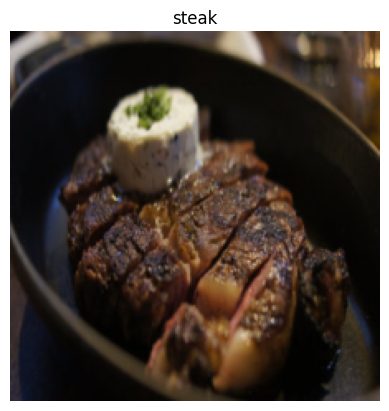

In [23]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape{image_out_of_conv_flattened.shape}")

In [24]:
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


In [25]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
flattened image map shape: torch.Size([1, 768, 196])


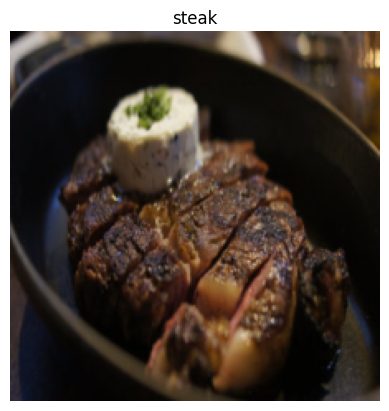

In [26]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"flattened image map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Rearrange
image_out_of_conv_flattened_reshape = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_reshape.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


In [28]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshape[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
print(f"the shape is {single_flattened_feature_map.shape}")
plt.axis(False)

the shape is torch.Size([1, 196])


(-0.5, 195.5, 0.5, -0.5)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module 

We want this module to do a few things.
1. create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [29]:
from torch import nn

patch_size = 16


class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):  # from Table 1 for ViT-bases
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 padding=0,
                                 stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        # create assertion to check that inputs are the correct shape.
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Imput image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {self.patch_size}"

        # forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # make sure the returned sequence embedding dimension are the right order.
        return x_flattened.permute(0, 2, 1)


In [30]:
set_seeds()

# create an instance of patch embedding layer

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
output patch embedding sequence shape: torch.Size([1, 196, 768])


In [31]:
16 * 16 * 3

768

In [32]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad).shape

### 4.6 create class token

In [33]:
patch_embedded_image

tensor([[[-0.6419,  0.2530, -0.2011,  ...,  0.3121, -0.0241,  0.1939],
         [-0.3971,  0.0378,  0.0111,  ...,  0.2745, -0.3247,  0.1434],
         [-0.2904,  0.0860, -0.0707,  ...,  0.2205, -0.1551,  0.0842],
         ...,
         [-0.0951, -0.0165, -0.0439,  ...,  0.0144,  0.0036,  0.0440],
         [-0.2890,  0.0858, -0.1194,  ...,  0.1862, -0.0676,  0.0536],
         [-0.2062, -0.0100, -0.1148,  ...,  0.1803, -0.0701,  0.1215]]],
       grad_fn=<PermuteBackward0>)

In [34]:
# get the catch size and embedding dimension

batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [35]:
# create class token embedding as a learnable parameters that share the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension,
                                      requires_grad=True))
class_token


Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [36]:
# add the class token embedding to the from of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_image_with_class_embedding)
print(
    f"Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6419,  0.2530, -0.2011,  ...,  0.3121, -0.0241,  0.1939],
         [-0.3971,  0.0378,  0.0111,  ...,  0.2745, -0.3247,  0.1434],
         ...,
         [-0.0951, -0.0165, -0.0439,  ...,  0.0144,  0.0036,  0.0440],
         [-0.2890,  0.0858, -0.1194,  ...,  0.1862, -0.0676,  0.0536],
         [-0.2062, -0.0100, -0.1148,  ...,  0.1803, -0.0701,  0.1215]]],
       grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


In [37]:
number_of_patches = int(height * width / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [38]:
# add the position embedding to the patch and class token embedding

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3581, 1.2530, 0.7989,  ..., 1.3121, 0.9759, 1.1939],
         [0.6029, 1.0378, 1.0111,  ..., 1.2745, 0.6753, 1.1434],
         ...,
         [0.9049, 0.9835, 0.9561,  ..., 1.0144, 1.0036, 1.0440],
         [0.7110, 1.0858, 0.8806,  ..., 1.1862, 0.9324, 1.0536],
         [0.7938, 0.9900, 0.8852,  ..., 1.1803, 0.9299, 1.1215]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 putting it all together

In [39]:
# Set the seeds
set_seeds()

# 1. Set the patch_size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
# embedding_dimension = int(height * width / patch_size ** 2)
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)  # learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Attention is all you need.

In [40]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Create a multi_head self_attention block ("MSA block" for short)"""

    def __init__(self,
                 embedding_dim=768,  # Hidden size D (embedding dimension) from Table 1 for Vit-Base
                 num_heads: int = 12,  # Heads from Table 1 for ViT-Base,
                 attn_dropout: int = 0):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)  # batch_first=True for input shape (batch, sequence, feature) -> (batch, num_patches, embedding_dimension)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)

        return attn_output


In [41]:
# Create an instance MSA block

multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
output shape of MSA block: torch.Size([1, 197, 768])


## Equation 3: MLP block = Fully_connected = Dense = Feed_Forward = Linear

In [42]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.1):
        super().__init__()
        # Create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the mlp
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [43]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of MSA block: {patched_image_through_msa_block.shape}")
print(f"output shape of MSA block: {patched_image_through_mlp_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
output shape of MSA block: torch.Size([1, 197, 768])


## TransformerEncoder

In [44]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,  # Hidden size D form table 1, 768 for ViT-Base
                 heads_num: int = 12,  # from table 1
                 mlp_size: int = 3072,  # from table 1
                 mlp_dropout: float = 0.1,  # from table 3
                 attn_dropout: float = 0):
        super().__init__()
        # self.layer_norm_1 = nn.LayerNorm(normalized_shape=embedding_dim)
        # self.attn_layer = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=heads_num, dropout=attn_dropout, batch_first=True)
        # self.layer_norm_2 = nn.LayerNorm(normalized_shape=embedding_dim)
        # self.mlp = nn.Sequential(
        #     nn.Linear(in_features=embedding_dim,out_features=mlp_size),
        #     nn.GELU(),
        #     nn.Dropout(p=mlp_dropout),
        #     nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        #     nn.Dropout(p=mlp_dropout)
        # )
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=heads_num,
                                                     attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [45]:
# Create an instance of transformer encoder block
transformer_encoder_block = TransformerEncoderBlock(embedding_dim=768,
                                                    heads_num=12,
                                                    mlp_size=3072,
                                                    mlp_dropout=0.1,
                                                    attn_dropout=0)

# get a summary
summary(transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Use pytorch for transformer

In [46]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# get a summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting all together

In [48]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int = 224,  # table 3
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layer: int = 12,  # table 1,
                 embedding_dim=768,  # Hidden Size D from table 1
                 mlp_size: int = 3072,  # table 1
                 num_heads: int = 12,  # table 1
                 attn_dropout: float = 0,
                 mlp_dropout: float = 0.1,  # table 3
                 embedding_dropout: float = 0.1,  # dropout for patch and position embeddings
                 num_classes: int = 1000):  # number of classes in our classification problem
        super().__init__()

        # make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

        # Calculate the number os patches (height*width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # Create learnable class embedding (needs to go at front os sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim),
                                               requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create the transformer encoder layer
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                      heads_num=num_heads,
                                      mlp_size=mlp_size,
                                      mlp_dropout=mlp_dropout,
                                      attn_dropout=attn_dropout) for _ in range(num_transformer_layer)]
        )

        # Create the classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        # Get the batch_size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1,
                                                  -1)  # -1 means to infer the dimension -> from (1, 1, 768) to (32, 1, 768)

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch embedding ("directly after adding positional- to patch embedding")
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to the transformer
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x

In [49]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=3)

vit(rand_image_tensor)

tensor([[-0.1739,  0.7276,  1.1629]], grad_fn=<AddmmBackward0>)

In [50]:
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [57]:
device = "gpu"

In [56]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3580 | train_acc: 0.4062 | test_loss: 2.7126 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.8135 | train_acc: 0.3398 | test_loss: 1.3306 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.5933 | train_acc: 0.4258 | test_loss: 2.0626 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.3419 | train_acc: 0.4023 | test_loss: 2.5002 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.4665 | train_acc: 0.2852 | test_loss: 1.4437 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2146 | train_acc: 0.2852 | test_loss: 1.1125 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1708 | train_acc: 0.4375 | test_loss: 1.3124 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.2554 | train_acc: 0.2734 | test_loss: 1.2810 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1286 | train_acc: 0.4805 | test_loss: 1.5076 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2129 | train_acc: 0.2695 | test_loss: 1.6218 | test_acc: 0.2604


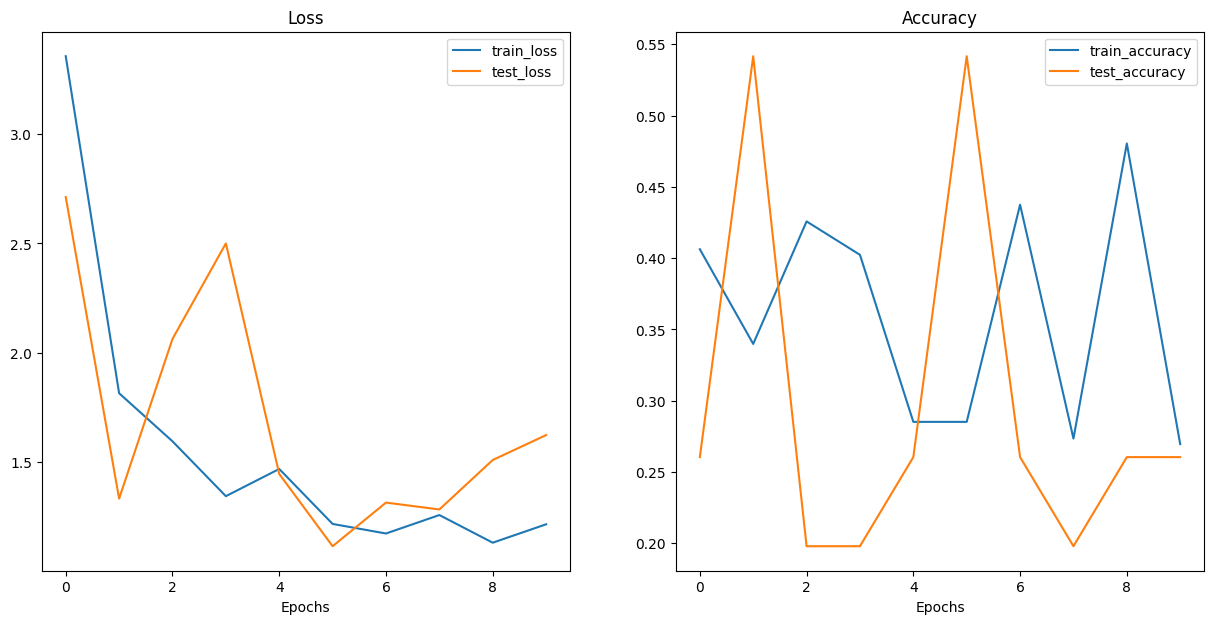

In [58]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Transfer Learning

In [59]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [60]:
 device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

In [81]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

In [82]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [83]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [84]:
from going_modular import data_setup

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, test_transform=vit_transforms, transform=vit_transforms, batch_size=32,
    num_workers=0)

In [85]:
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_result = engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained, optimizer=optimizer, loss_fn=loss_fn,
                                     epochs=5, device="cpu")

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_result)

## Save

In [ ]:
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="vit_pretrained")

In [87]:
from pathlib import Path

pretrained_vit_model_path = Path("models", "vit_pretrained").stat().st_size // (1024*1024)
pretrained_vit_model_path

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'models\\vit_pretrained'